In [18]:
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from scipy.stats import norm
import numpy as np
from tqdm import tqdm
import sys
sys.path.append('../src')
from models import open_pickle, filter_terms_not_in_wemodel

([<matplotlib.axis.YTick at 0x1a401834b48>,
 <a list of 5 Text yticklabel objects>)

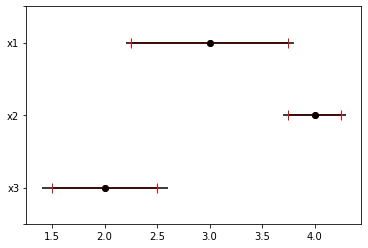

In [8]:
import matplotlib.pyplot as plt

x = [2, 4, 3]
y = [1, 3, 5]
errors = [0.5, 0.25, 0.75]
errors2 = [0.6, 0.3, 0.8]

plt.figure()
plt.errorbar(x, y, xerr=errors, fmt = 'o', color = 'r', capsize=5)
plt.errorbar(x, y, xerr=errors2, fmt = 'o', color = 'k')
plt.yticks((0, 1, 3, 5, 6), ('', 'x3', 'x2', 'x1','')) 

In [2]:
we_model_name = "sg_dim300_min100_win5"
we_vector_size = 300
we_model_dir = '../data/external/wiki-english/wiki-english-20171001/%s' % we_model_name

we_model = Word2Vec.load(we_model_dir+'/model.gensim')
print ('loading done!')

loading done!


In [3]:
RESULTS_FILEPATH = '../data/interim/association_metric_exps.pickle'
EXPERIMENT_DEFINITION_FILEPATH = '../data/interim/experiment_definitions.pickle'
SIGTEST_IMAGE_SAVE_FILEPATH = '../reports/figures/sigtest_intervals.png'

exp_def_dict = open_pickle(EXPERIMENT_DEFINITION_FILEPATH)
results_dict = open_pickle(RESULTS_FILEPATH)

In [13]:
results_dict[1]

defaultdict(dict,
            {'first': {'X_array': array([ 0.08113076,  0.18911934, -0.0954811 ,  0.13401467,  0.09897012,
                      0.19287561,  0.11558053,  0.06996465,  0.12096066,  0.12797187,
                      0.11942707,  0.18256408,  0.17806363,  0.17999095,  0.11687332,
                      0.08817419,  0.13236946,  0.10520089,  0.17782208,  0.09271343,
                      0.14632878,  0.13019669,  0.14671066,  0.15014505], dtype=float32),
              'Y_array': array([-0.04801004, -0.06460989, -0.08932857, -0.06297787, -0.40200305,
                     -0.1162259 ,  0.05139589, -0.29557508, -0.14763156,  0.11352445,
                     -0.1613886 , -0.0787251 , -0.19676779, -0.14766207, -0.03967397,
                      0.07359396, -0.04168847,  0.08253389, -0.0736915 , -0.06181172,
                      0.0839064 ,  0.08104831,  0.03454182, -0.13286161], dtype=float32),
              'X_mean': 0.12423697,
              'Y_mean': -0.068337,
            

In [19]:
def get_error(dist, interval_size):
    '''Interval size should be 0<x<1'''
    loc = np.mean(dist)
    scale = np.std(dist)
    err = loc - norm.ppf((1-interval_size)/2, loc=loc, scale=scale)

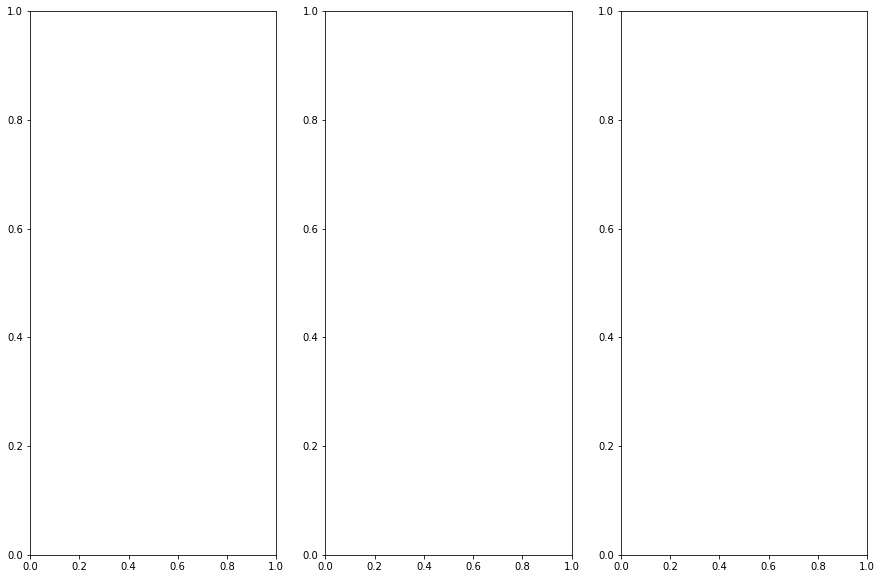

In [20]:
fig, axs = plt.subplots(1,3, figsize=(15,10))
for test_num in range(1,4):
    ax = axs[test_num - 1]
    errors_80 = [get_error(results_dict[i]['second'][f'sigtest_dist_{test_num}'], 0.8) for i in range(1,11)]
    errors_90 = [get_error(results_dict[i]['second'][f'sigtest_dist_{test_num}'], 0.9) for i in range(1,11)]
    errors_95 = [get_error(results_dict[i]['second'][f'sigtest_dist_{test_num}'], 0.95) for i in range(1,11)]